<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2026-1/notebooks/1b_retropropagacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Autor:* Pablo Uriel Benítez Ramírez

# Retropropagación en red densa

En este *notebook* se programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria presuponiendo una red densa con tres capas ocultas y una conexión residual que va de la salida de la primera capa oculta a la salida de la tercera capa oculta. 

Las neuronas de las capas ocultas cuentan con una función de activación 

$$
ReLU(z) = \max (0, z). 
$$
Por su parte, la capa de salida
está compuesta por una sola neurona sigmoide $σ(z) = 1/(1+e^{−z})$ . 
Para el entrenamiento se minimiza el promedio de la función de pérdida de entropía cruzada binaria
$$
ECB(\textbf{y,$\hat{\textbf{y}}$})= -\frac{1}{n}\sum_{i=1}^n\left[y^{(i)}\log\left(\hat{y}^{(i)}\right)+\left(1-y^{(i)}\right)\log\left(1-y^{(i)}\right)\right]
$$

In [37]:
import numpy as np
from math import floor

## Activación, pérdida y métricas
La red neuronal densa está compuesta por una capa de 2 entradas ($x_1$ y $x_2$), tres capas ocultas con 10 neuronas con función de activación ReLU. Esta función de activación se define como:

$$
ReLU(z) = \max (0, z). 
$$

Y una capa de salida con una sola neurona con función de activación sigmoide.

In [38]:
def relu(z):
  return np.maximum(0, z)

def sigmoide(z):
  return 1 / (1 + np.exp(-z))

La derivada de la función ReLU es,

$$
\frac{\partial ReLU (z)}{\partial z} = \begin{cases}
1 & \text{si }~z>0\\
0 & \text{si }~z\leq 0
\end{cases}
$$

In [39]:
def derivada_relu(z):
  return (z > 0).astype(z.dtype)

Podemos ver la operación XOR como una tarea de clasificación binaria a partir de 2 entradas. Por lo tanto, usaremos la función de pérdida de entropía cruzada binaria:

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\frac{1}{n}\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [40]:
def entropia_cruzada_binaria(y, p):
  p[p == 0] = np.nextafter(0., 1.)
  p[p == 1] = np.nextafter(1., 0.)
  return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())/y.shape[0]

Asimismo, calcularemos la exactitud para medir el rendimiento del modelo aprendido por la red neuronal densa:

$$
exactitud = \frac{correctos}{total}
$$

In [41]:
def exactitud(y, y_predicha):
  return (y == y_predicha).mean() * 100

Ahora, se define la función que propaga hacia adelante una entrada $\mathbf{X} \in \mathbb{R}^{m \times d}$.

 Como la red está compuesta de 4 capas densas (3 oculta y 1 de salida), tenemos 4 matrices de pesos con sus correspondientes vectores de sesgos
 
  $\{\mathbf{W}^{\{1\}} \in \mathbb{R}^{d \times l}, \mathbf{b}^{\{1\}} \in \mathbb{R}^{l \times 1}\}$ 
  
   $\{\mathbf{W}^{\{2\}} \in \mathbb{R}^{l \times k}, \mathbf{b}^{\{2\}} \in \mathbb{R}^{k \times 1}\}$ 

   $\{\mathbf{W}^{\{3\}} \in \mathbb{R}^{l \times k}, \mathbf{b}^{\{3\}} \in \mathbb{R}^{k \times 1}\}$ 

   $\{\mathbf{W}^{\{4\}} \in \mathbb{R}^{l \times k}, \mathbf{b}^{\{4\}} \in \mathbb{R}^{k \times 1}\}$ 
   
   de las capas ocultas y la capa de salida respectivamente. Así, podemos llevar a cabo la propagación hacia adelante en esta red de la siguiente manera:

$$
	\begin{split}
				\mathbf{A}^{\{1\}} & =  \mathbf{X} \\
				\mathbf{Z}^{\{2\}} & =  \mathbf{A}^{\{1\}} \cdot \mathbf{W}^{\{1\}} + \mathbf{b}^{\{1\}}\\
				\mathbf{A}^{\{2\}} & =  ReLU(\mathbf{Z}^{\{2\}}) \\
				\mathbf{Z}^{\{3\}} & =  \mathbf{A}^{\{2\}} \cdot \mathbf{W}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
				\mathbf{A}^{\{3\}} & =  ReLU(\mathbf{Z}^{\{3\}})\\
				\mathbf{Z}^{\{4\}} & =  \mathbf{A}^{\{3\}} \cdot \mathbf{W}^{\{3\}}  + \mathbf{b}^{\{3\}}+\mathbf{A}^{\{2\}}\\
				\mathbf{A}^{\{4\}} & =  ReLU(\mathbf{Z}^{\{4\}})\\
				\mathbf{Z}^{\{5\}} & =  \mathbf{A}^{\{4\}} \cdot \mathbf{W}^{\{4\}}  + \mathbf{b}^{\{4\}}\\
				\mathbf{A}^{\{5\}} & =  \sigma(\mathbf{Z}^{\{5\}})\\
				\mathbf{\hat{y}} & =  \mathbf{A}^{\{5\}}
		\end{split}
  $$

In [42]:
def hacia_adelante(X, W1, b1, W2, b2, W3, b3, W4, b4):

  
  
  Z2 = X @ W1 + b1
  A2 = relu(Z2)

  Z3 = A2 @ W2 + b2
  A3 = relu(Z3)

  Z4 = A3 @ W3 + b3 + A2
  A4 = relu(Z4)

  Z5 = A4 @ W4 + b4
  y_hat = sigmoide(Z5)
  


  return Z2, A2, Z3, A3, Z4, A4, Z5, y_hat

Para facilitar el entrenamiento definimos una función que ordene aleatoriamente y vaya generando lotes del conjunto completo.

In [43]:
def genera_lotes(X, y, t_lote=16):
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  perm = np.random.permutation(X.shape[0]) # se genera una permutación aleatoria
  Xperm = X[perm] # se reordenan las entradas y
  yperm = y[perm] # las entradas usando la permutación
  for lote in range(n_lotes): # se van tomando t_lote entradas y salidas
    Xlote = Xperm[lote * t_lote:(lote + 1) * t_lote]
    ylote = yperm[lote * t_lote:(lote + 1) * t_lote]
    yield Xlote, ylote

## Descenso por gradiente mediante retropropagación de errores
Se define la función para entrenar nuestra red neuronal usando descenso por gradiente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa empleamos el algoritmo de retropropagación. Para este caso, serían las siguientes expresiones.

Dado 
$$
\begin{align*}
Z_2&=X\cdot W_1+b_1,~~~~~~~~~~~~~~~A_2=ReLU(Z_2),\\
Z_3&=A_2\cdot W_2+b_2,~~~~~~~~~~~~~~~A_3=ReLU(Z_3),\\
Z_4&=A_3\cdot W_3+b_3+A_2,~~~~~~A_4=ReLU(Z_4),\\
Z_5&=A_4\cdot W_4+b_4,~~~~~~~~~~~~~~\hat{y}=\sigma(Z_5),
\end{align*}
$$
Sea 

$$
\begin{align*}
\boldsymbol{\delta}^{\{5\}} & =  \mathbf{\hat{y}}^{(i)} - \mathbf{y}^{(i)}
\end{align*}
$$

Capa de salida $(W_4,b_4)$:
$$
\begin{align*}
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{4\}}} & =  \mathbf{A}^{\{4\}\top} \cdot \boldsymbol{\delta}^{\{5\}}\\
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{4\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{5\}}_{j, :}\\
\boldsymbol{\delta}^{\{4\}} & =  (\boldsymbol{\delta}^{\{5\}}\cdot \mathbf{W}^{\{4\}\top}) \odot \frac{\partial \mathbf{A}^{\{4\}}}{\partial \mathbf{Z}^{\{4\}}}
\end{align*}
$$

tercera capa oculta $(W_3,b_3)$:
$$
\begin{align*}
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{3\}}} & =  \mathbf{A}^{\{3\}\top} \cdot \boldsymbol{\delta}^{\{4\}}\\
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{3\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{4\}}_{j, :}\\
\boldsymbol{\delta}^{\{3\}} & =  (\boldsymbol{\delta}^{\{4\}}\cdot \mathbf{W}^{\{3\}\top}) \odot \frac{\partial \mathbf{A}^{\{3\}}}{\partial \mathbf{Z}^{\{3\}}}
\end{align*}
$$

segunda capa oculta $(W_2,b_2)$:
$$
\begin{align*}
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{2\}}} & =  \mathbf{A}^{\{2\}\top} \cdot \boldsymbol{\delta}^{\{3\}}\\
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{2\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{3\}}_{j, :}\\
\boldsymbol{\delta}^{\{2\}} & =  (\boldsymbol{\delta}^{\{3\}}\cdot \mathbf{W}^{\{2\}\top}+\delta_4) \odot \frac{\partial \mathbf{A}^{\{2\}}}{\partial \mathbf{Z}^{\{2\}}}
\end{align*}
$$

primera capa oculta $(W_1,b_1)$:
$$
\begin{align*}
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{1\}}} & =  \mathbf{X}^{\{1\}\top} \cdot \boldsymbol{\delta}^{\{2\}}\\
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{1\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{2\}}_{j, :}
\end{align*}
$$




In [44]:
def retropropagacion(X, y, alpha = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y V
  # capas ocultas

  h= n_ocultas

  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
  b1 = np.zeros((1, n_ocultas))

  W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
  b2 = np.zeros((1, n_ocultas))

  W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
  b3 = np.zeros((1, n_ocultas))

  # capa de salida
  W4 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
  b4 = np.zeros((1, 1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))

  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote):
      Z2, A2, Z3, A3, Z4, A4, Z5, y_hat = hacia_adelante(Xlote, W1, b1, W2, b2, W3, b3, W4, b4)

      # cálculo de gradientes para W4 y b4 por retropropagación 
      # (capa de salida)
      dZ5 = y_hat - ylote
      dW4 = A4.T @ dZ5
      db4 = dZ5.sum(axis=0)

      # cálculo de gradientes para W3 y b3 por retropropagación 
      # (tercera capa oculta)
      dA4 = dZ5 @ W4.T
      dZ4 = dA4 * derivada_relu(Z4)
      dW3 = A3.T @ dZ4
      db3 = dZ4.sum(axis=0)

      # cálculo de gradientes para W2 y b2 por retropropagación 
      # (segunda capa oculta)
      dA3 = dZ4 @ W3.T
      dZ3 = dA3 * derivada_relu(Z3)
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      # (primera capa oculta)
      dA2 = (dZ3 @ W2.T) + dZ4
      dZ2 = dA2 * derivada_relu(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # IMPORTANTE
      # la actualización de los parámetros
      # debe hacerse de forma simultánea
      W4 -= alpha * dW4; b4 -= alpha * db4
      W3 -= alpha * dW3; b3 -= alpha * db3
      W2 -= alpha * dW2; b2 -= alpha * db2
      W1 -= alpha * dW1; b1 -= alpha * db1

      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria(ylote, y_hat)
      exactitudes[i] += exactitud(ylote, np.round(y_hat))

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, W3, b3, W4, b4, perdidas, exactitudes

## Evaluación preliminar con XOR
Para probar nuestra red, generamos los ejemplos correspondientes a la operación XOR.

In [45]:
# ejemplo (XOR)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0, 1, 1, 0]]).T

Entrenamos nuestra red con estos ejemplos por 500 épocas usando una tasa de aprendizaje $\alpha = 0.25$.

In [46]:
np.random.seed(42)
W1, b1, W2, b2, W3, b3, W4, b4, perdidas, exactitudes = retropropagacion(X,
                                                         y,
                                                         alpha = 0.25,
                                                         n_epocas = 500,
                                                         n_ocultas = 10,
                                                         t_lote=1)

Epoch 0: Pérdida = 0.8487640962012761 Exactitud = 25.0
Epoch 1: Pérdida = 0.7496289086781646 Exactitud = 50.0
Epoch 2: Pérdida = 0.7028970670148921 Exactitud = 25.0
Epoch 3: Pérdida = 0.6590893677695135 Exactitud = 75.0
Epoch 4: Pérdida = 0.6426990269479634 Exactitud = 75.0
Epoch 5: Pérdida = 0.608602878429872 Exactitud = 75.0
Epoch 6: Pérdida = 0.5999652778030802 Exactitud = 75.0
Epoch 7: Pérdida = 0.5460204400101678 Exactitud = 75.0
Epoch 8: Pérdida = 0.5528896586641351 Exactitud = 75.0
Epoch 9: Pérdida = 0.5192114432764052 Exactitud = 75.0
Epoch 10: Pérdida = 0.5042453827841347 Exactitud = 75.0
Epoch 11: Pérdida = 0.4921999664166196 Exactitud = 75.0
Epoch 12: Pérdida = 0.48707549869747957 Exactitud = 75.0
Epoch 13: Pérdida = 0.4786925466954387 Exactitud = 75.0
Epoch 14: Pérdida = 0.46370575769868294 Exactitud = 75.0
Epoch 15: Pérdida = 0.46886913576625355 Exactitud = 75.0
Epoch 16: Pérdida = 0.447053952189862 Exactitud = 75.0
Epoch 17: Pérdida = 0.4326166790260921 Exactitud = 75.0
E

Graficamos el valor de la pérdida y la exactitud en cada época para ver el comportamiento de nuestra red durante el entrenamiento:

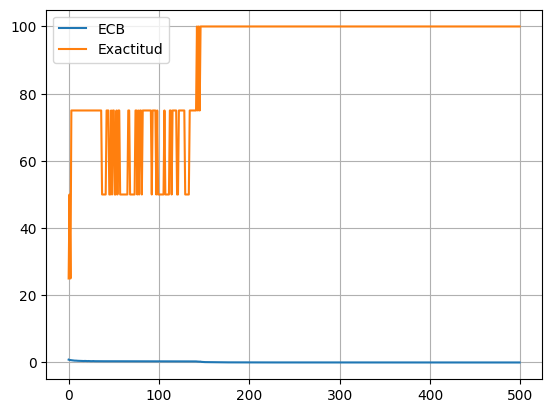

In [47]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

Nota: solo llega al 75% si se define  $\alpha=0.5$.

## 1. Clasificación no lineal
Ahora se entrena y evalúa la red mediante descenso por gradiente y el algoritmo de retropropagación de errores

In [48]:
np.random.seed(42)
Xreal = np.random.randn(1000, 2)
yreal = np.logical_xor(Xreal[:, 0] > 0, Xreal[:, 1] > 0)

Dividimos el conjunto de datos generado.

In [49]:
from sklearn.model_selection import train_test_split

Xent, Xval, yent, yval = train_test_split(Xreal, yreal, test_size=0.2, random_state=42)

Definimos una función para graficar el conjunto de datos:

In [50]:
from sklearn.model_selection import train_test_split

def grafica_datos(modelo, X_ent, y_ent, X_val, y_val, frontera=None):
  fig, ax = plt.subplots()
  ax.scatter(X_ent[:, 0], X_ent[:, 1], c=y_ent, cmap=plt.cm.coolwarm,
             s=30, edgecolors='k', label='Validación')
  ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.coolwarm,
             s=30, alpha=0.5, edgecolors='k', label='Validación')

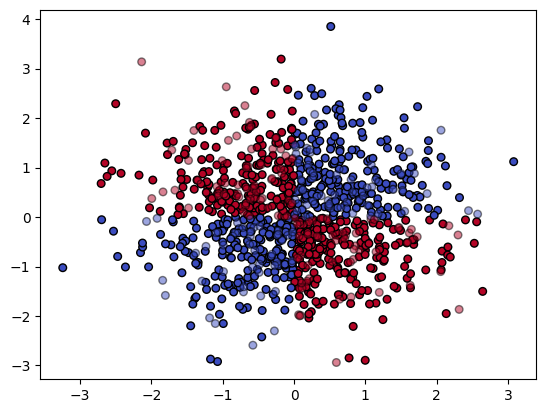

In [51]:
grafica_datos(_, Xent, yent, Xval, yval, frontera=False)

Finalmente, entrenamos nuestra red con estos ejemplos por 500 épocas usando una tasa de aprendizaje $\alpha = 0.05$.

In [52]:
np.random.seed(0)
W1, b1, W2, b2, W3, b3, W4, b4, perdidas, exactitudes = retropropagacion(Xent,
                                                         yent[:, np.newaxis],
                                                         alpha = 0.05,
                                                         t_lote=16,
                                                         n_epocas = 500,
                                                         n_ocultas = 10)

Epoch 0: Pérdida = 0.44246569169619965 Exactitud = 78.625
Epoch 1: Pérdida = 0.3789796950966959 Exactitud = 85.25
Epoch 2: Pérdida = 0.21069869619845044 Exactitud = 92.25
Epoch 3: Pérdida = 0.24439356982359847 Exactitud = 91.875
Epoch 4: Pérdida = 0.20614901033007776 Exactitud = 92.25
Epoch 5: Pérdida = 0.11695694779502067 Exactitud = 96.0
Epoch 6: Pérdida = 0.2650634186674913 Exactitud = 92.5
Epoch 7: Pérdida = 0.14576307700243418 Exactitud = 94.0
Epoch 8: Pérdida = 0.14340502224598792 Exactitud = 94.75
Epoch 9: Pérdida = 0.16215008882532803 Exactitud = 94.375
Epoch 10: Pérdida = 0.13751523412612948 Exactitud = 93.0
Epoch 11: Pérdida = 0.09054022064125848 Exactitud = 96.5
Epoch 12: Pérdida = 0.12890545458363398 Exactitud = 95.625
Epoch 13: Pérdida = 0.09121147931210861 Exactitud = 97.0
Epoch 14: Pérdida = 0.09192783664244829 Exactitud = 96.375
Epoch 15: Pérdida = 0.19926332151295423 Exactitud = 94.5
Epoch 16: Pérdida = 0.18005540662813427 Exactitud = 92.25
Epoch 17: Pérdida = 0.313051

Graficamos el valor de la pérdida y la exactitud en cada época para ver el comportamiento de nuestra red durante el entrenamiento:

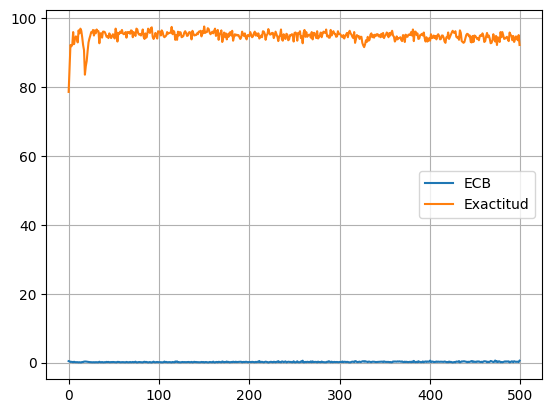

In [53]:
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

Evalúamos el desempeño del modelo en el conjunto de validación:

In [54]:
_, _, _,_,_,_,_, y_hat = hacia_adelante(Xval, W1, b1, W2, b2, W3, b3, W4, b4)
print(exactitud(yval[:, np.newaxis], np.round(y_hat).astype(bool)))

94.5


## Comparación de resultados sin residual y con sigmoide


In [55]:
def derivada_sigmoide(x):
    s = sigmoide(x)
    return s * (1 - s)

$$
\begin{align*}
				\mathbf{A}^{\{1\}} & =  \mathbf{X} \\
				\mathbf{Z}^{\{2\}} & =  \mathbf{A}^{\{1\}} \cdot \mathbf{W}^{\{1\}} + \mathbf{b}^{\{1\}}\\
				\mathbf{A}^{\{2\}} & =  \sigma(\mathbf{Z}^{\{2\}}) \\
				\mathbf{Z}^{\{3\}} & =  \mathbf{A}^{\{2\}} \cdot \mathbf{W}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
				\mathbf{A}^{\{3\}} & =  \sigma(\mathbf{Z}^{\{3\}})\\
				\mathbf{Z}^{\{4\}} & =  \mathbf{A}^{\{3\}} \cdot \mathbf{W}^{\{3\}}  + \mathbf{b}^{\{3\}}\\
				\mathbf{A}^{\{4\}} & =  \sigma(\mathbf{Z}^{\{4\}})\\
				\mathbf{Z}^{\{5\}} & =  \mathbf{A}^{\{4\}} \cdot \mathbf{W}^{\{4\}}  + \mathbf{b}^{\{4\}}\\
				\mathbf{A}^{\{5\}} & =  \sigma(\mathbf{Z}^{\{5\}})\\
				\mathbf{\hat{y}} & =  \mathbf{A}^{\{5\}}
\end{align*}
$$

In [56]:
def hacia_adelante_nr(X, W1, b1, W2, b2, W3, b3, W4, b4):

  Z2 = X @ W1 + b1
  A2 = sigmoide(Z2)

  Z3 = A2 @ W2 + b2
  A3 = sigmoide(Z3)

  Z4 = A3 @ W3 + b3 # se elimina el residual
  A4 = sigmoide(Z4)

  Z5 = A4 @ W4 + b4
  y_hat = sigmoide(Z5)
  

  return Z2, A2, Z3, A3, Z4, A4, Z5, y_hat

### Descenso por gradiente 
Se define la función para entrenar nuestra red neuronal usando descenso por gradiente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa empleamos el algoritmo de retropropagación. Para este caso, serían las siguientes expresiones.

Dado 
$$
\begin{align*}
Z_2&=X\cdot W_1+b_1,~~~~~~~~~~~~~~~~A_2=\sigma(Z_2),\\
Z_3&=A_2\cdot W_2+b_2,~~~~~~~~~~~~~~~A_3=\sigma(Z_3),\\
Z_4&=A_3\cdot W_3+b_3,~~~~~~~~~~~~~~~A_4=\sigma(Z_4),\\
Z_5&=A_4\cdot W_4+b_4,~~~~~~~~~~~~~~~~~~\hat{y}=\sigma(Z_5),
\end{align*}
$$
Sea
$$ 
\begin{align*}
\boldsymbol{\delta}^{\{5\}} & =  \mathbf{\hat{y}}^{(i)} - \mathbf{y}^{(i)}
\end{align*}
$$
Capa de salida $(W_4,b_4)$:
$$
\begin{align*}
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{4\}}} & =  \mathbf{A}^{\{4\}\top} \cdot \boldsymbol{\delta}^{\{5\}}\\
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{4\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{5\}}_{j, :}\\
\boldsymbol{\delta}^{\{4\}} & =  (\boldsymbol{\delta}^{\{5\}}\cdot \mathbf{W}^{\{4\}\top}) \odot \frac{\partial \mathbf{A}^{\{4\}}}{\partial \mathbf{Z}^{\{4\}}}
\end{align*}
$$
Tercera capa oculta $(W_3,b_3)$:
$$
\begin{align*}
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{3\}}} & =  \mathbf{A}^{\{3\}\top} \cdot \boldsymbol{\delta}^{\{4\}}\\
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{3\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{4\}}_{j, :}\\
\boldsymbol{\delta}^{\{3\}} & =  (\boldsymbol{\delta}^{\{4\}}\cdot \mathbf{W}^{\{3\}\top}) \odot \frac{\partial \mathbf{A}^{\{3\}}}{\partial \mathbf{Z}^{\{3\}}}
\end{align*}
$$
segunda capa oculta $(W_2,b_2)$:
$$
\begin{align*}
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{2\}}} & =  \mathbf{A}^{\{2\}\top} \cdot \boldsymbol{\delta}^{\{3\}}\\
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{2\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{3\}}_{j, :}\\
\boldsymbol{\delta}^{\{2\}} & =  (\boldsymbol{\delta}^{\{3\}}\cdot \mathbf{W}^{\{2\}\top}) \odot \frac{\partial \mathbf{A}^{\{2\}}}{\partial \mathbf{Z}^{\{2\}}}
\end{align*}
$$
primera capa oculta $(W_1,b_1)$:
$$
\begin{align*}
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{1\}}} & =  \mathbf{X}^{\{1\}\top} \cdot \boldsymbol{\delta}^{\{2\}}\\
\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{1\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{2\}}_{j, :}
\end{align*}
$$

In [57]:
def retropropagacion_nr(X, y, alpha = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y V
  # capas ocultas

  h= n_ocultas

  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
  b1 = np.zeros((1, n_ocultas))

  W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
  b2 = np.zeros((1, n_ocultas))

  W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
  b3 = np.zeros((1, n_ocultas))

  # capa de salida
  W4 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
  b4 = np.zeros((1, 1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))

  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote):
      Z2, A2, Z3, A3, Z4, A4, Z5, y_hat = hacia_adelante_nr(Xlote, W1, b1, W2, b2, W3, b3, W4, b4)

      # cálculo de gradientes para W4 y b4 por retropropagación 
      # (capa de salida)
      dZ5 = y_hat - ylote
      dW4 = A4.T @ dZ5
      db4 = dZ5.sum(axis=0)

      # cálculo de gradientes para W3 y b3 por retropropagación 
      # (tercera capa oculta)
      dA4 = dZ5 @ W4.T
      dZ4 = dA4 * derivada_sigmoide(Z4)
      dW3 = A3.T @ dZ4
      db3 = dZ4.sum(axis=0)

      # cálculo de gradientes para W2 y b2 por retropropagación 
      # (segunda capa oculta)
      dA3 = dZ4 @ W3.T
      dZ3 = dA3 * derivada_sigmoide(Z3)
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      # (primera capa oculta)
      dA2 = (dZ3 @ W2.T) 
      dZ2 = dA2 * derivada_sigmoide(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # IMPORTANTE
      # la actualización de los parámetros
      # debe hacerse de forma simultánea
      W4 -= alpha * dW4; b4 -= alpha * db4
      W3 -= alpha * dW3; b3 -= alpha * db3
      W2 -= alpha * dW2; b2 -= alpha * db2
      W1 -= alpha * dW1; b1 -= alpha * db1

      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria(ylote, y_hat)
      exactitudes[i] += exactitud(ylote, np.round(y_hat))

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, W3, b3, W4, b4, perdidas, exactitudes

Finalmente, entrenamos nuestra red con estos ejemplos por 500 épocas usando una tasa de aprendizaje $\alpha = 0.01$.

In [58]:
np.random.seed(0)
W1, b1, W2, b2, W3, b3, W4, b4, perdidasi, exactitudesi = retropropagacion_nr(Xent,
                                                         yent[:, np.newaxis],
                                                         alpha = 0.01,
                                                         t_lote=16,
                                                         n_epocas = 500,
                                                         n_ocultas = 10)

Epoch 0: Pérdida = 0.6979775617964619 Exactitud = 49.25
Epoch 1: Pérdida = 0.6982586872084586 Exactitud = 46.0
Epoch 2: Pérdida = 0.6962068319846453 Exactitud = 47.5
Epoch 3: Pérdida = 0.695960095936438 Exactitud = 47.25
Epoch 4: Pérdida = 0.6946735751699599 Exactitud = 51.625
Epoch 5: Pérdida = 0.6946848913148479 Exactitud = 50.625
Epoch 6: Pérdida = 0.6962597478139975 Exactitud = 49.125
Epoch 7: Pérdida = 0.6983173081845178 Exactitud = 47.125
Epoch 8: Pérdida = 0.6961690464406778 Exactitud = 47.75
Epoch 9: Pérdida = 0.6944998772592423 Exactitud = 51.875
Epoch 10: Pérdida = 0.6971350391343745 Exactitud = 48.75
Epoch 11: Pérdida = 0.6968345438348007 Exactitud = 49.125
Epoch 12: Pérdida = 0.6967878725605131 Exactitud = 48.25
Epoch 13: Pérdida = 0.6959930901638808 Exactitud = 51.125
Epoch 14: Pérdida = 0.6970009295083706 Exactitud = 49.25
Epoch 15: Pérdida = 0.6960865772826405 Exactitud = 50.625
Epoch 16: Pérdida = 0.6965817148102351 Exactitud = 50.375
Epoch 17: Pérdida = 0.6903436637562

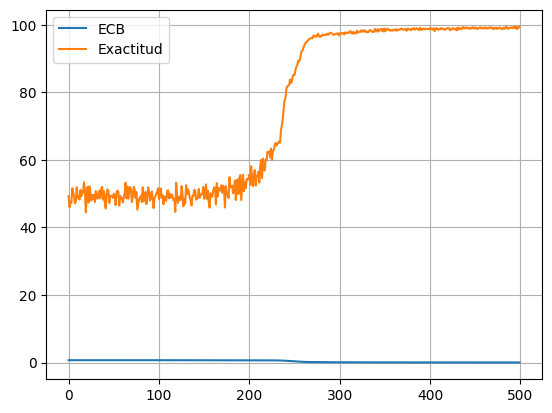

In [59]:
plt.plot(np.arange(perdidasi.size), perdidasi, label='ECB')
plt.plot(np.arange(exactitudesi.size), exactitudesi, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

Evaluamos el desempeño del modelo

In [60]:
_, _, _,_,_,_,_, y_hat = hacia_adelante_nr(Xval, W1, b1, W2, b2, W3, b3, W4, b4)
print(exactitud(yval[:, np.newaxis], np.round(y_hat).astype(bool)))

97.5


## Estudia el efecto en el entrenamiento de no usar el promedio en la función ECB esto es
$$
    \begin{align*}
        ECB(\textbf{y,$\hat{\textbf{y}}$})= -\sum_{i=1}^n\left[y^{(i)}\log\left(\hat{y}^{(i)}\right)+\left(1-y^{(i)}\right)\log\left(1-y^{(i)}\right)\right]
    \end{align*}
    $$

In [61]:
def entropia_cruzada_binaria_snp(y, p):
  p[p == 0] = np.nextafter(0., 1.)
  p[p == 1] = np.nextafter(1., 0.)
  return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

In [62]:
def retropropagacion_snp(X, y, alpha = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y V
  # capas ocultas

  h= n_ocultas

  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
  b1 = np.zeros((1, n_ocultas))

  W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
  b2 = np.zeros((1, n_ocultas))

  W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
  b3 = np.zeros((1, n_ocultas))

  # capa de salida
  W4 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
  b4 = np.zeros((1, 1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))

  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote):
      Z2, A2, Z3, A3, Z4, A4, Z5, y_hat = hacia_adelante(Xlote, W1, b1, W2, b2, W3, b3, W4, b4)

      # cálculo de gradientes para W4 y b4 por retropropagación 
      # (capa de salida)
      dZ5 = y_hat - ylote
      dW4 = A4.T @ dZ5
      db4 = dZ5.sum(axis=0)

      # cálculo de gradientes para W3 y b3 por retropropagación 
      # (tercera capa oculta)
      dA4 = dZ5 @ W4.T
      dZ4 = dA4 * derivada_relu(Z4)
      dW3 = A3.T @ dZ4
      db3 = dZ4.sum(axis=0)

      # cálculo de gradientes para W2 y b2 por retropropagación 
      # (segunda capa oculta)
      dA3 = dZ4 @ W3.T
      dZ3 = dA3 * derivada_relu(Z3)
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      # (primera capa oculta)
      dA2 = (dZ3 @ W2.T) + dZ4
      dZ2 = dA2 * derivada_relu(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # IMPORTANTE
      # la actualización de los parámetros
      # debe hacerse de forma simultánea
      W4 -= alpha * dW4; b4 -= alpha * db4
      W3 -= alpha * dW3; b3 -= alpha * db3
      W2 -= alpha * dW2; b2 -= alpha * db2
      W1 -= alpha * dW1; b1 -= alpha * db1

      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria_snp(ylote, y_hat)
      exactitudes[i] += exactitud(ylote, np.round(y_hat))

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, W3, b3, W4, b4, perdidas, exactitudes

In [70]:
np.random.seed(0)
W1, b1, W2, b2, W3, b3, W4, b4, perdidasj, exactitudesj = retropropagacion_snp(Xent,
                                                         yent[:, np.newaxis],
                                                         alpha = 0.01,
                                                         t_lote=16,
                                                         n_epocas = 500,
                                                         n_ocultas = 10)

Epoch 0: Pérdida = 9.643841980715996 Exactitud = 62.375
Epoch 1: Pérdida = 7.114793386667367 Exactitud = 80.375
Epoch 2: Pérdida = 3.5588243293007253 Exactitud = 94.0
Epoch 3: Pérdida = 2.297998661582494 Exactitud = 95.625
Epoch 4: Pérdida = 1.9476786497601695 Exactitud = 95.0
Epoch 5: Pérdida = 1.4375042579310875 Exactitud = 96.75
Epoch 6: Pérdida = 1.43976549576645 Exactitud = 96.875
Epoch 7: Pérdida = 1.3238787977116393 Exactitud = 96.625
Epoch 8: Pérdida = 1.7328429549938196 Exactitud = 95.125
Epoch 9: Pérdida = 2.150405940588836 Exactitud = 94.5
Epoch 10: Pérdida = 1.833038187832376 Exactitud = 94.5
Epoch 11: Pérdida = 1.3189001535381686 Exactitud = 96.5
Epoch 12: Pérdida = 1.180724233533198 Exactitud = 97.125
Epoch 13: Pérdida = 1.1468282372576617 Exactitud = 97.0
Epoch 14: Pérdida = 1.4405284987857894 Exactitud = 96.25
Epoch 15: Pérdida = 1.3321305786388569 Exactitud = 96.125
Epoch 16: Pérdida = 1.2293983030947209 Exactitud = 96.125
Epoch 17: Pérdida = 1.649709014264426 Exactitu

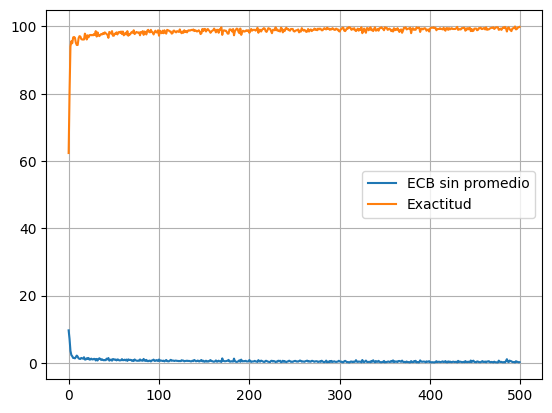

In [75]:
plt.plot(np.arange(perdidasj.size), perdidasj, label='ECB sin promedio')
plt.plot(np.arange(exactitudesj.size), exactitudesj, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
_, _, _,_,_,_,_, y_hat = hacia_adelante_nr(Xval, W1, b1, W2, b2, W3, b3, W4, b4)
print(exactitud(yval[:, np.newaxis], np.round(y_hat).astype(bool)))

47.0


In [76]:
def retropropagacion_nr_snp(X, y, alpha = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y V
  # capas ocultas

  h= n_ocultas

  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
  b1 = np.zeros((1, n_ocultas))

  W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
  b2 = np.zeros((1, n_ocultas))

  W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
  b3 = np.zeros((1, n_ocultas))

  # capa de salida
  W4 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
  b4 = np.zeros((1, 1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))

  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote):
      Z2, A2, Z3, A3, Z4, A4, Z5, y_hat = hacia_adelante_nr(Xlote, W1, b1, W2, b2, W3, b3, W4, b4)

      # cálculo de gradientes para W4 y b4 por retropropagación 
      # (capa de salida)
      dZ5 = y_hat - ylote
      dW4 = A4.T @ dZ5
      db4 = dZ5.sum(axis=0)

      # cálculo de gradientes para W3 y b3 por retropropagación 
      # (tercera capa oculta)
      dA4 = dZ5 @ W4.T
      dZ4 = dA4 * derivada_sigmoide(Z4)
      dW3 = A3.T @ dZ4
      db3 = dZ4.sum(axis=0)

      # cálculo de gradientes para W2 y b2 por retropropagación 
      # (segunda capa oculta)
      dA3 = dZ4 @ W3.T
      dZ3 = dA3 * derivada_sigmoide(Z3)
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      # (primera capa oculta)
      dA2 = (dZ3 @ W2.T) 
      dZ2 = dA2 * derivada_sigmoide(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # IMPORTANTE
      # la actualización de los parámetros
      # debe hacerse de forma simultánea
      W4 -= alpha * dW4; b4 -= alpha * db4
      W3 -= alpha * dW3; b3 -= alpha * db3
      W2 -= alpha * dW2; b2 -= alpha * db2
      W1 -= alpha * dW1; b1 -= alpha * db1

      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria_snp(ylote, y_hat)
      exactitudes[i] += exactitud(ylote, np.round(y_hat))

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, W3, b3, W4, b4, perdidas, exactitudes

In [77]:
np.random.seed(0)
W1, b1, W2, b2, W3, b3, W4, b4, perdidas, exactitudes = retropropagacion_nr_snp(Xent,
                                                         yent[:, np.newaxis],
                                                         alpha = 0.01,
                                                         t_lote=16,
                                                         n_epocas = 500,
                                                         n_ocultas = 10)

Epoch 0: Pérdida = 11.16764098874339 Exactitud = 49.25
Epoch 1: Pérdida = 11.172138995335338 Exactitud = 46.0
Epoch 2: Pérdida = 11.139309311754324 Exactitud = 47.5
Epoch 3: Pérdida = 11.135361534983009 Exactitud = 47.25
Epoch 4: Pérdida = 11.114777202719358 Exactitud = 51.625
Epoch 5: Pérdida = 11.114958261037566 Exactitud = 50.625
Epoch 6: Pérdida = 11.14015596502396 Exactitud = 49.125
Epoch 7: Pérdida = 11.173076930952284 Exactitud = 47.125
Epoch 8: Pérdida = 11.138704743050845 Exactitud = 47.75
Epoch 9: Pérdida = 11.111998036147877 Exactitud = 51.875
Epoch 10: Pérdida = 11.154160626149991 Exactitud = 48.75
Epoch 11: Pérdida = 11.149352701356811 Exactitud = 49.125
Epoch 12: Pérdida = 11.14860596096821 Exactitud = 48.25
Epoch 13: Pérdida = 11.135889442622092 Exactitud = 51.125
Epoch 14: Pérdida = 11.152014872133929 Exactitud = 49.25
Epoch 15: Pérdida = 11.137385236522247 Exactitud = 50.625
Epoch 16: Pérdida = 11.145307436963762 Exactitud = 50.375
Epoch 17: Pérdida = 11.04549862010008

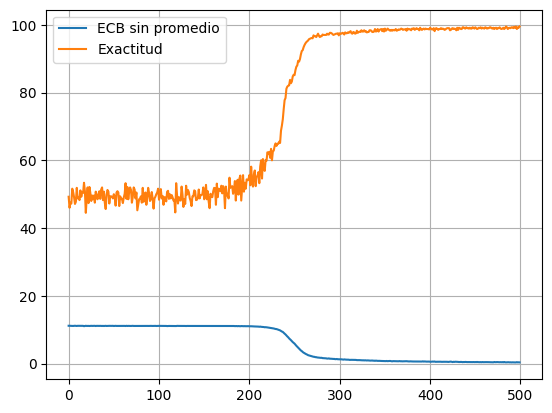

In [79]:
plt.plot(np.arange(perdidas.size), perdidas, label='ECB sin promedio')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
_, _, _,_,_,_,_, y_hat = hacia_adelante_nr(Xval, W1, b1, W2, b2, W3, b3, W4, b4)
print(exactitud(yval[:, np.newaxis], np.round(y_hat).astype(bool)))

97.5
